## Data cleaning and preprocessing

Data cleaning steps
1. Clean body of each dataset, exctracting just the words
2. Remove non-english rows using langdetect
3. Combine all datasets

We only combine in the last step as the datasets are large.

Note: files are imported from local folder, raw datasets are stored in google drive (https://drive.google.com/drive/folders/11juebPd9DGK0v2lUr5O6eddafeY73Ryk?usp=sharing)

In [1]:
import pandas as pd
import re

In [2]:
def cleaning(text):

    # Ensure correct data type
    text = str(text) 

    # Lowercasing
    text = text.lower()
    
    text = re.sub(r'^(from|to|cc|bcc|subject|sent|date):.*?\n', '', text, flags=re.MULTILINE | re.IGNORECASE) # Remove email headers
    text = re.sub(r"https?://\S+|www\.\S+", "", text)  # Remove URLs
    text = re.sub(r"[^a-z\s]", "", text)  # Keep only alphabets and spaces (removes non-Latin characters like Chinese, Korean)
    text = re.sub("\n", " ", text) # Remove new line indicator
    text = re.sub(r"^(Subject: re :|Subject:)\s*", "", text) # Remove repetitive words
    text = re.sub(r'\s+', ' ', text).strip() # Remove excessive whitespace

    return text

In [3]:
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException

In [4]:
def get_language(text):
    try:
        cleaned_text = str(text).strip()
        if not cleaned_text:
            return 'empty' 
        lang = detect(cleaned_text)
        return lang
    
    except LangDetectException:
        # cannto detect language
        return 'unknown'
    
    except Exception as e:
        # in case of unexpected error
        return 'error'

In [5]:
df = pd.read_csv("../data/raw/emails.csv")
df['body'] = df['text']
df['label'] = df['spam']
df['cleaned_body'] = df['body'].apply(cleaning)
df['language'] = df['cleaned_body'].apply(get_language)

In [6]:
df['language'].value_counts()

language
en    5680
pl      27
nl       4
fr       3
de       3
pt       3
es       2
tr       1
hr       1
ro       1
ca       1
sv       1
et       1
Name: count, dtype: int64

In [7]:
df[df['language'] != 'en'].sample(5) # checking

,text,spam,body,label,cleaned_body,language
5115,"Subject: grades pam , another team : elena ...",0,"Subject: grades pam , another team : elena ...",0,subject grades pam another team elena chilkina...,sv
2759,"Subject: hello vince , nie bardzo wiem czy pi...",0,"Subject: hello vince , nie bardzo wiem czy pi...",0,subject hello vince nie bardzo wiem czy pisac ...,pl
1641,Subject: drogi vincenty . skoro ty byles na ty...,0,Subject: drogi vincenty . skoro ty byles na ty...,0,subject drogi vincenty skoro ty byles na tyle ...,pl
2450,"Subject: aiesec polska - eurolds 2000 jarek ,...",0,"Subject: aiesec polska - eurolds 2000 jarek ,...",0,subject aiesec polska eurolds jarek czy enron ...,pl
764,Subject: ) . your message subject : just to ...,1,Subject: ) . your message subject : just to ...,1,subject your message subject just to her was n...,fr


In [8]:
df1 = df.loc[df['language'] == 'en', ['body','cleaned_body', 'label']]
df1.sample(2)

,body,cleaned_body,label
5621,Subject: new pc lyn : can you tell me the st...,subject new pc lyn can you tell me the status ...,0
4647,Subject: re : i am zhendong sure thing ! - -...,subject re i am zhendong sure thing original m...,0


In [9]:
df = pd.read_csv("../data/raw/spam_ham_dataset.csv")
df['body'] = df['text']
df['label'] = df['label_num']
df['cleaned_body'] = df['body'].apply(cleaning)
df['language'] = df['cleaned_body'].apply(get_language)

In [10]:
df['language'].value_counts()

language
en       4889
empty     110
ca         53
es         24
nl         24
fr         13
de          9
cy          8
cs          5
so          4
sk          4
pt          3
fi          3
da          3
it          3
af          2
pl          2
hr          2
et          2
sl          2
id          1
lt          1
sv          1
sw          1
hu          1
sq          1
Name: count, dtype: int64

In [11]:
df[df['language'] == 'empty'].sample(2) # we can see that the cleaned body is empty as the body only had subject without content so we can remove them

,Unnamed: 0,label,text,label_num,body,cleaned_body,language
3933,4241,1,Subject: you can be smart !\r\n,1,Subject: you can be smart !\r\n,,empty
2844,5077,1,Subject: ? ? ? ? 13 ? ? ? ? ? ? ? * ? * ? * ?\...,1,Subject: ? ? ? ? 13 ? ? ? ? ? ? ? * ? * ? * ?\...,,empty


In [12]:
df2 = df.loc[df['language'] == 'en', ['body','cleaned_body', 'label']] # removes all entries that are not english
df2.sample(2)

,body,cleaned_body,label
3245,Subject: strapon fucked cunt lickin dyke .\r\n...,she especially loves black penis that can bang...,1
3478,Subject: re : patchs work better then pillz\r\...,worlds first dermal p atch technology for p ni...,1


In [13]:
df = pd.concat([df1,df2], ignore_index=True)

lst_standard_datasets = ["CEAS_08.csv", "Enron.csv", "Ling.csv", "SpamAssasin.csv", "TREC_07.csv", "Nigerian_5.csv", "Nazario_5.csv"]

for dataset in lst_standard_datasets:
    temp_df = pd.read_csv("../data/raw/"+dataset)[['body','label']]
    temp_df['cleaned_body'] = temp_df['body'].apply(cleaning)
    temp_df['language'] = temp_df['cleaned_body'].apply(get_language)
    df = pd.concat([df, temp_df.loc[temp_df['language'] == 'en', ['body', 'cleaned_body', 'label']]], ignore_index=True)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149395 entries, 0 to 149394
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   body          149395 non-null  object
 1   cleaned_body  149395 non-null  object
 2   label         149395 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 3.4+ MB


In [15]:
df.sample(5)

,body,cleaned_body,label
126042,Looking for some help here you perl geniuses y...,looking for some help here you perl geniuses y...,0
99870,I tried with R-2.4.1 and R-2.5.0 - it works fo...,i tried with r and r it works for me can you p...,0
123060,There are a couple of ways but I think you nee...,there are a couple of ways but i think you nee...,0
142651,FROM THE DESK OF:\nBARRISTER AMINU KANO\nPRICI...,from the desk of barrister aminu kano pricipal...,1
140357,"Hey Harry,\n\nHere are the hydro plant capacit...",hey harry here are the hydro plant capacities ...,0


In [16]:
df.isna().sum()

body            0
cleaned_body    0
label           0
dtype: int64

In [17]:
df['cleaned_body'].duplicated().sum()

23387

In [18]:
df.drop_duplicates(subset = ['cleaned_body'], inplace=True)
df['cleaned_body'].duplicated().sum()

0

Data preprocessing steps
1. Tokenization
2. Remove stopwords
3. Lemmatization
-- we choose to perform lemmatization instead of stemming to identify the original meaning of the word

In [19]:
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [20]:
subject_start = df['cleaned_body'].str.startswith('subject')
df.loc[subject_start, 'cleaned_body'] = df.loc[subject_start, 'cleaned_body'].apply(lambda x: x[len('subject'):].lstrip())
df.sample(5)

,body,cleaned_body,label
109828,"Hire,\ni am here sitting in the internet caffe...",hire i am here sitting in the internet caffe f...,1
84599,"On Mon, 2002-07-22 at 06:50, che wrote: > that...",on mon at che wrote thats the correct lines to...,0
110901,Come into a great modify on your Meds\n\nsafe ...,come into a great modify on your meds safe typ...,1
84180,Udhay Shankar N wrote:\n > Heh. The name of th...,udhay shankar n wrote heh the name of the band...,0
25281,\nDelightful replica watches at Replica Classi...,delightful replica watches at replica classics...,1


In [21]:
subject_start.sum()

5502

In [22]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    words = word_tokenize(text)
    
    # Remove stopwords
    words = [word for word in words if word not in stop_words]
    
    # Lemmatization
    words = [lemmatizer.lemmatize(word) for word in words]

    return words

df['tokens'] = df['cleaned_body'].apply(preprocess)

In [23]:
df.sample(5)

,body,cleaned_body,label,tokens
103795,"\n\n\nCBSNews.com\n\n\n\n\n\n\nMay 1, 2007\n\n...",cbsnewscom may home us world politics scitech ...,0,"[cbsnewscom, may, home, u, world, politics, sc..."
137248,\n\n\n\nWhile we may have high ex...,while we may have high expectations of our ass...,1,"[may, high, expectation, associate, also, give..."
109308,----------------------------------------------...,revno revisionid tridgesambaorgxpdpemxn parent...,0,"[revno, revisionid, tridgesambaorgxpdpemxn, pa..."
20815,"On 16/02/2008, Russ Fineman wrote:\n> SUSE 10...",on russ fineman wrote suse i just updated my k...,0,"[rus, fineman, wrote, suse, updated, kernel, s..."
6636,Subject: best free adult dating\r\nsearch for ...,search for sexual partners in your areaclick h...,1,"[search, sexual, partner, areaclick]"


In [24]:
df['label'].value_counts()

label
0    66378
1    59630
Name: count, dtype: int64

## Feature 1: BoW + Tf-idf

Code taken from BoW + Tf-idf feature engineering file

In [25]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import ast
import numpy as np

In [26]:
full_df = df.copy()

In [27]:
full_df['tokens_str'] = full_df['tokens'].apply(lambda x:" ".join(x))

bow_vectorizer = CountVectorizer(stop_words='english', max_features= 10000, min_df=4, ngram_range =(1,3),token_pattern=r'\b[a-zA-Z]{3,15}\b')
X_bow = bow_vectorizer.fit_transform(full_df['tokens_str'])
print(X_bow.shape)
bow_features = bow_vectorizer.get_feature_names_out()

(126008, 10000)


In [28]:
bow_counts = np.asarray(X_bow.sum(axis=0)).flatten()
bow_freq = pd.Series(bow_counts, index=bow_features).sort_values(ascending=False)
print(bow_freq.head(20))

email          63454
enron          63007
new            56919
time           50895
list           48658
company        47877
ect            45245
message        42643
like           42115
use            40848
need           38122
price          37832
information    37780
work           36379
make           35338
know           34815
day            33694
business       31780
file           31550
year           31034
dtype: int64


In [29]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english',max_features=10000,min_df=4,ngram_range=(1, 3),token_pattern=r'\b[a-zA-Z]{3,15}\b')
X_tfidf = tfidf_vectorizer.fit_transform(full_df['tokens_str'])
tfidf_features = tfidf_vectorizer.get_feature_names_out()

tfidf_sum = np.asarray(X_tfidf.sum(axis=0)).flatten()

tfidf_scores = pd.Series(tfidf_sum, index = tfidf_features).sort_values(ascending=False)

print(tfidf_scores.head(20))
tfidf_scores.sample(30)

email      2173.334595
list       1804.921308
new        1590.860337
like       1576.355593
time       1569.681647
price      1549.608836
enron      1535.675549
watch      1505.761320
message    1476.386464
wrote      1468.642353
need       1409.921733
use        1401.670394
know       1391.239837
work       1327.393787
day        1325.160336
ect        1314.986902
com        1298.686251
file       1295.099809
thanks     1285.478434
mailing    1277.643382
dtype: float64


make change                   51.736497
dealt                         49.251190
invalid                       62.409306
joining                       49.410435
dedicated                     62.226352
great time                    57.931440
released                     213.177958
dragon                        18.224059
president bush                47.067570
web post                       5.148311
sfnet email sponsored         97.836951
forward seeing                33.875843
announced additional          16.513531
spend way like                41.417685
winbindd                      26.443813
beginner                      33.786181
enron research                25.757158
total submission               7.521733
failed                       235.452556
unset                         35.571142
term california epmi           6.207684
company                     1088.342140
support private customer      16.431868
bullish                      170.645109
phone mobile                 113.609086


In [30]:
combined_features = pd.concat([bow_freq, tfidf_scores], axis = 1)

combined_features.columns = ['BoW Frequency', 'TF-IDF Score']

combined_features = combined_features.sort_values(by='BoW Frequency', ascending=False)
combined_features.to_csv('../data/processed/combined_features_bow_tfidf.csv')
print(combined_features.head(20))

             BoW Frequency  TF-IDF Score
email                63454   2173.334595
enron                63007   1535.675549
new                  56919   1590.860337
time                 50895   1569.681647
list                 48658   1804.921308
company              47877   1088.342140
ect                  45245   1314.986902
message              42643   1476.386464
like                 42115   1576.355593
use                  40848   1401.670394
need                 38122   1409.921733
price                37832   1549.608836
information          37780   1127.387070
work                 36379   1327.393787
make                 35338   1228.701996
know                 34815   1391.239837
day                  33694   1325.160336
business             31780    921.072173
file                 31550   1295.099809
year                 31034    912.352302


In [31]:
from scipy.sparse import hstack 

In [32]:
X_btf = hstack([
    X_bow,
    X_tfidf
])

## Feature 2: N-grams + Tf-idf
Code taken from N-grams feature engineering file

In [34]:
X_text = full_df['cleaned_body']

In [36]:
# excluded trigrams for performance
word_vectorizer_tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=1000, stop_words='english', min_df = 5, max_df = 0.8, sublinear_tf=True) 
X_word_grams_tfidf = word_vectorizer_tfidf.fit_transform(X_text)

In [37]:
char_vectorizer_tfidf = TfidfVectorizer(analyzer='char', ngram_range=(3, 5), max_features=500, min_df = 10, max_df = 0.7, sublinear_tf=True)
X_char_grams_tfidf = char_vectorizer_tfidf.fit_transform(X_text)

In [38]:
X_full = hstack([
    X_btf,
    X_word_grams_tfidf,
    X_char_grams_tfidf
])

In [40]:
X_full[:5].todense()


matrix([[0.        , 0.        , 0.        , ..., 0.06496826, 0.09413251,
         0.09717517],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.134829  , 0.0606428 ,
         0.06260296],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

Split into training and testing sets

In [41]:
y = full_df['label']

In [ ]:
# checking
print("Shape of X_full:", X_full.shape) 
print("Shape of y:", y.shape)            

Shape of X_full: (126008, 21500)
Shape of y: (126008,)


In [44]:
from sklearn.model_selection import train_test_split

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size=0.2, random_state=4263, stratify=y)

In [47]:
from scipy.sparse import save_npz

# Save the sparse feature matrices in .npz format
save_npz("X_train_sparse.npz", X_train)
save_npz("X_test_sparse.npz", X_test)

# Save the labels in .npy format
np.save("y_train.npy", y_train)
np.save("y_test.npy", y_test)

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

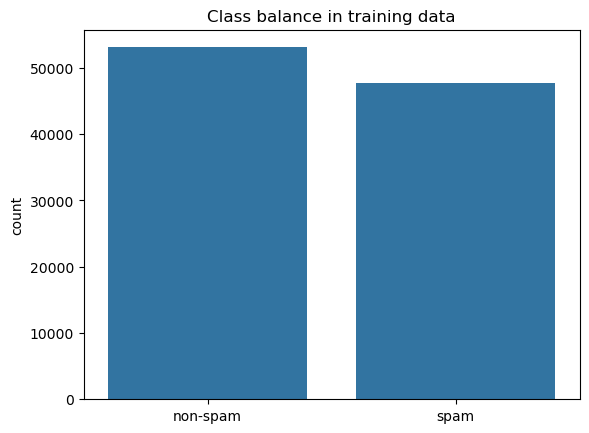

In [ ]:
count = y_train.value_counts()
labels = {0:'non-spam', 1:'spam'}

ax = sns.barplot(x = labels, y = count).set_title("Class balance in training data")

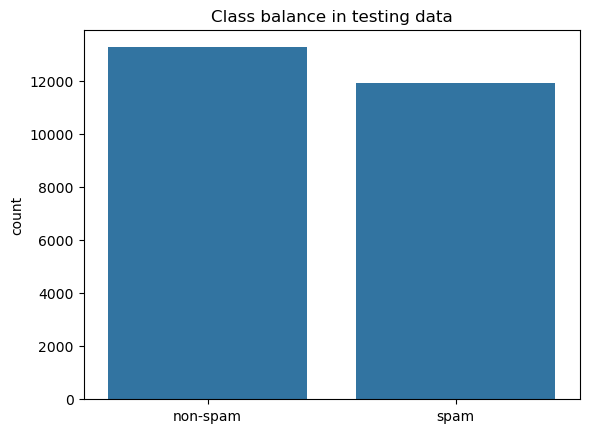

In [ ]:
count = y_test.value_counts()
labels = {0:'non-spam', 1:'spam'}

ax = sns.barplot(x = labels, y = count).set_title("Class balance in testing data")

In [ ]:
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (100806, 21500)
Shape of y_train: (100806,)
Shape of X_test: (25202, 21500)
Shape of y_test: (25202,)
